<a href="https://colab.research.google.com/github/yqxiao28/424FinalProject/blob/main/Penguins_WaddleMovement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler

import json
import urllib.request as ur
from collections import Counter
from io import BytesIO
from math import ceil, pi
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q ipympl

# Data Cleaning

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Fieldday/PENGUINS/DATA/PENGUINS_20230304_to_20230305_1cdcf20_events.tsv", sep = "	")

df.head()

,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
0,23030409211767084,PENGUINS,2023-03-04 15:21:18.980000,application_start,"{""http_user_agent"": ""128.104.153.129"", ""remote...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},{},0
1,23030409211767084,PENGUINS,2023-03-04 15:21:18.731000,open_menu,"{""http_user_agent"": ""128.104.153.129"", ""remote...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""3.391"", ""posX"": ""0.00...",1
2,23030409211767084,PENGUINS,2023-03-04 15:21:18.732000,headset_on,"{""http_user_agent"": ""128.104.153.129"", ""remote...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""3.453"", ""posX"": ""-2.7...",2
3,23030409211767084,PENGUINS,2023-03-04 15:21:19.747000,viewport_data,"{""gaze_data_package"": ""{\""pos\"":\""-2.765,2.076...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""3.453"", ""posX"": ""-2.7...",3
4,23030409211767084,PENGUINS,2023-03-04 15:21:19.747000,left_hand_data,"{""http_user_agent"": ""128.104.153.129"", ""left_h...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""4.455"", ""posX"": ""-2.7...",4


In [ ]:
df.loc[(df['event_name'] == "enter_region")].head()

,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
742,23030409293275910,PENGUINS,2023-03-04 15:56:35.195000,enter_region,"{""http_user_agent"": ""128.104.153.129"", ""region...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""31.385"", ""posX"": ""-1....",557
1755,23030409580345875,PENGUINS,2023-03-04 16:04:58.940000,enter_region,"{""http_user_agent"": ""128.104.153.129"", ""region...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""19.888"", ""current_reg...",242
1760,23030409580345875,PENGUINS,2023-03-04 16:04:59.400000,enter_region,"{""http_user_agent"": ""128.104.153.129"", ""region...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""20.403"", ""current_reg...",247
1896,23030409580345875,PENGUINS,2023-03-04 16:05:37.970000,enter_region,"{""http_user_agent"": ""128.104.153.129"", ""region...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""58.590"", ""current_reg...",383
1906,23030409580345875,PENGUINS,2023-03-04 16:05:38.975000,enter_region,"{""http_user_agent"": ""128.104.153.129"", ""region...",GAME,588,NaN,3,"-1 day, 18:00:00",NaN,{},"{""seconds_from_launch"": ""60.117"", ""posX"": ""1.7...",393


In [ ]:
# df_id = df.loc[(df['session_id'] == 23021315314512253)]
df_id = df.loc[(df['event_name'] == "player_waddle")]

for i in df_id['event_data']:
  # df_id['event_data'] = df_id['event_data'].replace([i], [eval(i)])
  res = eval(i)
  del res["http_user_agent"]
  del res["object_id"]
  del res["remote_addr"]
  del res["rotW"]
  del res["rotX"]
  del res["rotY"]
  del res["rotZ"]
  del res["server_time"]
  # print(res)
  # remove_key = res.pop("http_user_agent", None)
  # remove_key = res.pop("object_id", None)
  df_id['event_data'] = df_id['event_data'].replace([i], [res])

<ipython-input-6-df14f169d528>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['event_data'] = df_id['event_data'].replace([i], [res])


In [ ]:
position_lst = df_id['event_data'].values.tolist()
old_posX_lst = []
old_posY_lst = []
old_posZ_lst = []
posX_lst = []
posY_lst = []
posZ_lst = []
for i in range(len(position_lst)):
  old_posX_lst.append(float(position_lst[i]['old_posX']))
  old_posY_lst.append(float(position_lst[i]['old_posY']))
  old_posZ_lst.append(float(position_lst[i]['old_posZ']))
  posX_lst.append(float(position_lst[i]['posX']))
  posY_lst.append(float(position_lst[i]['posY']))
  posZ_lst.append(float(position_lst[i]['posZ']))
df_id['old_posX'] = old_posX_lst
df_id['old_posY'] = old_posY_lst
df_id['old_posZ'] = old_posZ_lst
df_id['posX'] = posX_lst
df_id['posY'] = posY_lst
df_id['posZ'] = posZ_lst
df_pos = df_id[['old_posX','old_posY','old_posZ','posX','posY','posZ']]

<ipython-input-7-5203f0e78098>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['old_posX'] = old_posX_lst
<ipython-input-7-5203f0e78098>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id['old_posY'] = old_posY_lst
<ipython-input-7-5203f0e78098>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [ ]:
df_id
region_lst = []
for i in df_id['game_state']:
  # df_id['event_data'] = df_id['event_data'].replace([i], [eval(i)])
  res = eval(i)
  region_lst.append(res['current_region'])
df_region = df_id.copy()

In [ ]:
df_region['region'] = region_lst
df_region = df_region[['session_id','old_posX','old_posY','old_posZ','posX','posY','posZ','region']]
df_region.head()

,session_id,old_posX,old_posY,old_posZ,posX,posY,posZ,region
269,23030409293275910,-2.765,2.036,57.012,-2.494,2.036,57.071,none
660,23030409293275910,-2.494,1.956,57.071,-1.986,1.956,56.846,none
664,23030409293275910,-1.986,1.896,56.846,-1.723,1.896,56.936,none
668,23030409293275910,-1.723,1.920,56.936,-1.844,1.920,57.186,none
672,23030409293275910,-1.844,1.981,57.186,-2.111,1.981,57.263,none


# 3D Graphics

In [ ]:
cmap = plt.get_cmap('viridis')
region_names = df_region['region'].unique().tolist()
colors = cmap(np.linspace(0, 1, len(region_names)))
region_names

['none',
 'MirrorInner',
 'HillUpInner',
 'EntranceInner',
 'SnowballBowlingInner',
 'HillDownInner',
 'ChimesInner',
 'BridgeInner',
 'MatingDPathInner',
 'MatingDInner',
 'ProtectNestPathInner',
 'ProtectNestInner']

In [ ]:
colmap = {name: n for n, name in enumerate(set(region_names))}

In [ ]:
!pip install ggplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.2 MB/s eta 0:00:00


In [ ]:
!pip install plotnine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

## player waddle map

Unity uses Z for top down view

### 2D plots

In [ ]:
px.scatter(df_region, x='posX', y='posZ', color='region')



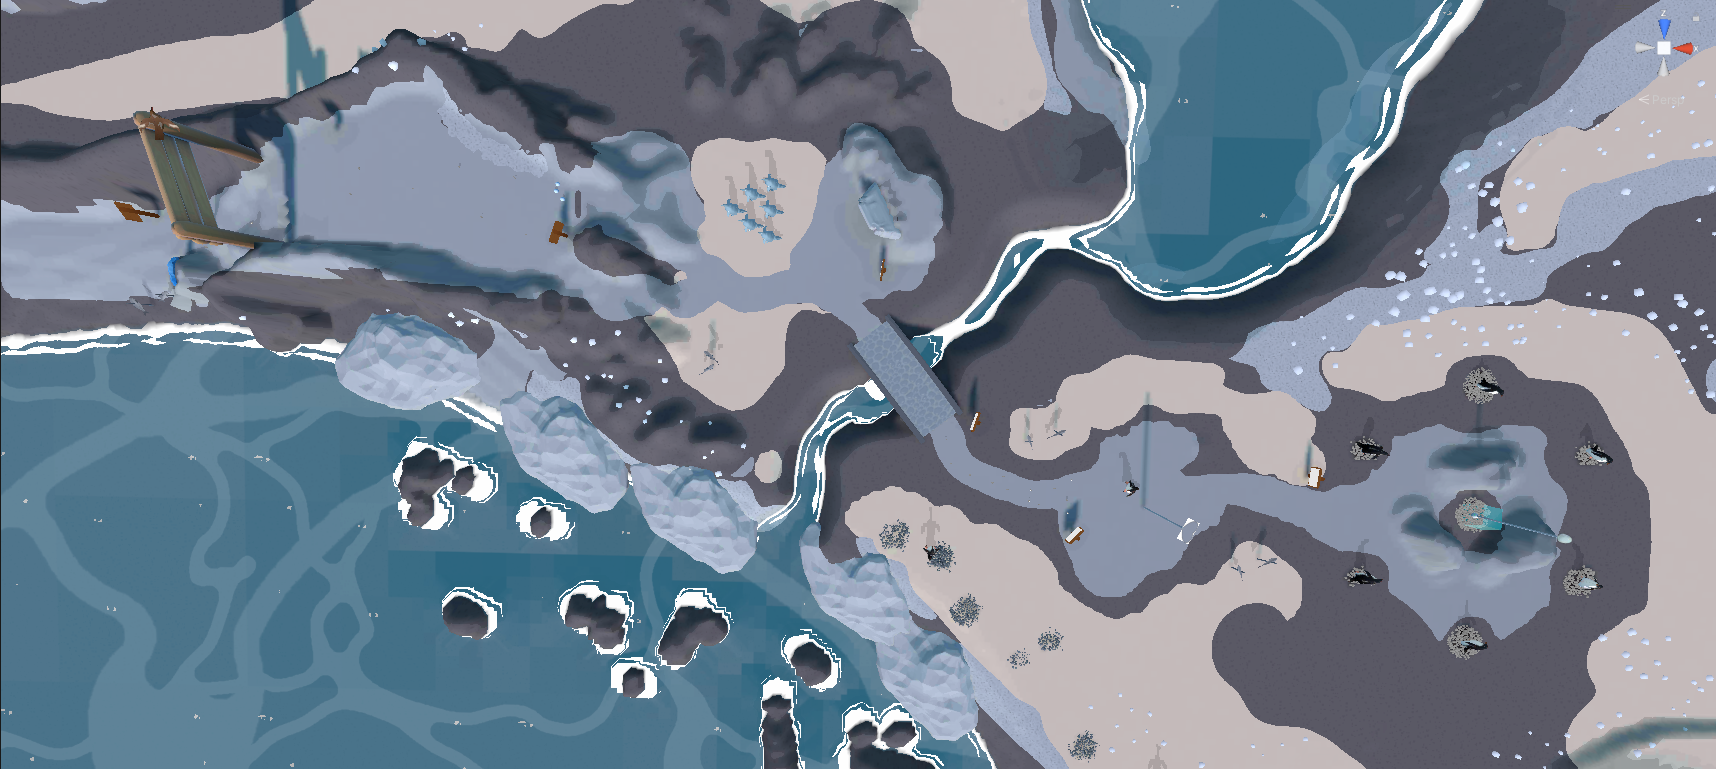

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import base64

image1_filename = '/content/drive/MyDrive/Fieldday/PENGUINS/PenguinsMap.png'
polar_light = base64.b64encode(open(image1_filename, 'rb').read())

fig = go.Figure()

# fig.add_trace(go.Scatter(x= [1, 1.75, 2.5, 3.5], y=[-1, 3, 0, 3,  5],
#                          mode='markers',
#                          marker_size=20,
#                          marker_color="#ffd700"),
#               row=1, col=1)

fig.add_trace(go.Scatter(x= df_region['posX'], y=df_region['posZ'], mode='markers',
                         marker_symbol='triangle-down',
                         marker_size=5, marker_color='red'))
# fig.update_layout(dict(
#                     source='data:image/png;base64,{}'.format(polar_light.decode()),
#                     xref="paper", 
#                     yref="paper",
#                     x=0, 
#                     y=0,  #position of the upper left corner of the image in subplot 2,1
#                     sizex=1, sizey=0.5,
#                     xanchor="left",
#                     yanchor="top",
#                     sizing="stretch",
#                     layer="below")    )
fig.add_layout_image(
        dict(
            source='data:image/png;base64,{}'.format(polar_light.decode()),
            xref="paper", 
                    yref="paper",
                    x=0, 
                    y=1.2,  #position of the upper left corner of the image in subplot 2,1
                    sizex=1, sizey=1,
                    xanchor="left",
                    yanchor="top",
                    sizing="stretch",
                    layer="below")    
)

fig.update_xaxes(showgrid=False, zeroline=False)
fig.update_yaxes(showgrid=False, zeroline=False)


### 3D plots

In [ ]:
fig = px.scatter_3d(df_region, x='posX', y='posZ', z='posY',  size_max=1,
              color='region')
fig.update_traces(marker_size = 5)
fig.show()

## Player Waddle Analysis

In [ ]:
fig = px.scatter(df_region, x="posX", y="posZ", color="region", marginal_y="violin",
           marginal_x="box", trendline="ols", template="simple_white")
fig.show()

heatmap for waddle position

In [ ]:
fig = px.density_heatmap(df_region, x="posX", y="posZ", marginal_x="rug", marginal_y="histogram")
fig.show()

In [ ]:
# df = px.data.carshare()
# df.head()
# fig = px.scatter_mapbox(df, lat="centroid_lat", lon="centroid_lon", color="peak_hour", size="car_hours",
#                   color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10,
#                   mapbox_style="carto-positron")
# fig.show()

In [ ]:
df_event = pd.read_csv("/content/drive/MyDrive/Fieldday/PENGUINS/DATA/PENGUINS_20230304_to_20230305_1cdcf20_session-features.tsv", sep = "	")


In [ ]:
ls = []
for i in df_event['RegionWaddleCount']:
  ls.append(eval(i))
  # print(type(i))
  # del res['None']
  # df_event['RegionWaddleCount'] = df_event['RegionWaddleCount'].replace([i], [res])


In [ ]:
df_event['RegionWaddleCount'] = ls

In [ ]:
# import plotly.express as px
# dfgap = px.data.gapminder()
# fig = px.scatter(dfgap.query("year==2007"), x="gdpPercap", y="lifeExp", size="pop", color="continent",
#            hover_name="country", log_x=True, size_max=60)
# fig.show()

In [ ]:
from datetime import datetime, timedelta
import datetime
total_seconds = []
for i in df_event['SessionDuration']:
  t = datetime.datetime.strptime(i , '%H:%M:%S.%f')
  delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
  
  total_seconds.append(delta.total_seconds()/60)


df_event['SessionDuration'] = total_seconds

In [ ]:
df_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PlayerID              0 non-null      float64
 1   SessionID             20 non-null     int64  
 2   EatFishCount          20 non-null     int64  
 3   EventsBeforeFail      20 non-null     object 
 4   GazeCount             20 non-null     object 
 5   MirrorWaddleDuration  20 non-null     object 
 6   PickupRockCount       20 non-null     int64  
 7   PlayerWaddleCount     20 non-null     int64  
 8   RegionWaddleCount     20 non-null     object 
 9   SessionDuration       20 non-null     float64
 10  SnowBallDuration      20 non-null     object 
dtypes: float64(2), int64(4), object(5)
memory usage: 1.8+ KB


In [ ]:
total_seconds2 = []
for i in df_event['SnowBallDuration']:
  t = 0
  if (len(i) == 7):
    t = datetime.datetime.strptime(i , '%H:%M:%S')
  elif (len(i) == 14):
    t = datetime.datetime.strptime(i , '%H:%M:%S.%f')
  else:
    t = datetime.datetime.strptime('0:00:00' , '%H:%M:%S')
  delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
  total_seconds2.append(delta.total_seconds())
df_event['SnowBallDuration'] = total_seconds2

In [ ]:
df_waddle_region = df_event['RegionWaddleCount'].apply(pd.Series)

In [ ]:
fig = px.bar(df_waddle_region, x=df_waddle_region.index, y=df_waddle_region.columns, title="Player_Waddle Count")
fig.show()

In [ ]:
for i in df_event['SessionID']:
  df_event['SessionID'] = df_event['SessionID'].replace([i], [str(i)])

In [ ]:
df_waddle_region['SessionID'] = df_event['SessionID']
# df_waddle_region['SessionDuration'] = df_event['SessionDuration']
df_waddle_region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   None                  20 non-null     int64 
 1   MirrorInner           20 non-null     int64 
 2   HillUpInner           20 non-null     int64 
 3   EntranceInner         20 non-null     int64 
 4   SnowballBowlingInner  20 non-null     int64 
 5   HillDownInner         20 non-null     int64 
 6   ChimesInner           20 non-null     int64 
 7   BridgeInner           20 non-null     int64 
 8   MatingDPathInner      20 non-null     int64 
 9   MatingDInner          20 non-null     int64 
 10  ProtectNestPathInner  20 non-null     int64 
 11  ProtectNestInner      20 non-null     int64 
 12  SessionID             20 non-null     object
dtypes: int64(12), object(1)
memory usage: 2.2+ KB


In [ ]:
# df_waddle_region
fig = px.line(df_waddle_region, x='SessionID', y=df_waddle_region.columns)
fig.show()

In [ ]:
df_event

,PlayerID,SessionID,EatFishCount,EventsBeforeFail,GazeCount,MirrorWaddleDuration,PickupRockCount,PlayerWaddleCount,RegionWaddleCount,SessionDuration,SnowBallDuration
0,NaN,23030409211767084,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [1, 1], ""BigRock01"": [0, 0], ""Br...","{""waddle"": 0, ""duration"": 0}",0,0,"{'None': 0, 'MirrorInner': 0, 'HillUpInner': 0...",1.016667,0.0
1,NaN,23030409293275910,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [3, 6], ""BigRock01"": [0, 1], ""Br...","{""waddle"": 11, ""duration"": 823.959}",0,11,"{'None': 0, 'MirrorInner': 0, 'HillUpInner': 0...",28.116667,0.0
2,NaN,23030409324073591,0,"['right_hand_data', 'gaze_object_begin', 'left...","{""BigRock00"": [3, 3], ""BigRock01"": [0, 1], ""Br...","{""waddle"": 0, ""duration"": 0}",0,0,"{'None': 0, 'MirrorInner': 0, 'HillUpInner': 0...",0.133333,0.0
3,NaN,23030409425388775,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [0, 1], ""BigRock01"": [0, 0], ""Br...","{""waddle"": 17, ""duration"": 0}",0,17,"{'None': 0, 'MirrorInner': 0, 'HillUpInner': 0...",22.900000,0.0
4,NaN,23030409580345875,13,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [0, 0], ""BigRock01"": [1, 1], ""Br...","{""waddle"": 5, ""duration"": 10.775}",19,245,"{'None': 0, 'MirrorInner': 18, 'HillUpInner': ...",17.633333,2.0
5,NaN,23030410060910012,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [0, 0], ""BigRock01"": [0, 0], ""Br...","{""waddle"": 0, ""duration"": 0}",0,0,"{'None': 0, 'MirrorInner': 0, 'HillUpInner': 0...",2.566667,0.0
6,NaN,23030410090284401,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [0, 0], ""BigRock01"": [0, 0], ""Br...","{""waddle"": 0, ""duration"": 0}",0,0,"{'None': 0, 'MirrorInner': 0, 'HillUpInner': 0...",0.083333,0.0
7,NaN,23030410092628231,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [0, 2], ""BigRock01"": [0, 0], ""Br...","{""waddle"": 6, ""duration"": 8.42}",12,151,"{'None': 0, 'MirrorInner': 8, 'HillUpInner': 1...",25.200000,9.0
8,NaN,23030410160944868,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [2, 3], ""BigRock01"": [0, 1], ""Br...","{""waddle"": 6, ""duration"": 24.03}",0,9,"{'None': 0, 'MirrorInner': 3, 'HillUpInner': 0...",19.083333,0.0
9,NaN,23030410345415912,0,"['right_hand_data', 'left_hand_data', 'right_h...","{""BigRock00"": [0, 4], ""BigRock01"": [0, 2], ""Br...","{""waddle"": 5, ""duration"": 7.973}",21,191,"{'None': 0, 'MirrorInner': 7, 'HillUpInner': 8...",10.583333,0.0


In [ ]:
df_waddle_region.iloc[4][:-1]

None                     0
MirrorInner             18
HillUpInner              9
EntranceInner           18
SnowballBowlingInner    15
HillDownInner           24
ChimesInner              6
BridgeInner             25
MatingDPathInner        32
MatingDInner            18
ProtectNestPathInner    12
ProtectNestInner        63
Name: 4, dtype: object

In [ ]:
# plotly setup
plot_rows=20
plot_cols=13

lst1 = list(range(1,plot_rows+1))
lst2 = list(range(1,plot_cols+1))

fig = make_subplots(rows=1, cols=1, subplot_titles=df_waddle_region['SessionID'], insets=[{'l': 0.1, 'b': 0.1, 'h':1}])
for j in range(1,20):
  fig.add_trace(go.Scatter(x=df_waddle_region.columns[:-1], y=df_waddle_region.iloc[j-1][:-1],
                                    name = df_waddle_region['SessionID'][j-1],
                                    mode = 'lines',
                                    ))
# fig.add_trace(go.Scatter(x=df_waddle_region.columns[:-1], y=df_waddle_region[df_waddle_region.columns[1-1]],
#                                     name = df_waddle_region['SessionID'][1-1],
#                                     mode = 'lines',
#                                     ),

#                           row=1,
#                         col=1)
# fig.add_trace(go.Scatter(x=df_waddle_region.columns[:-1], y=df_waddle_region[df_waddle_region.columns[5-1]],
#                                     name = df_waddle_region['SessionID'][5-1],
#                                     mode = 'lines',
#                                     ),

#                           row=1,
#                         col=1)


# fig.update_layout(height=12000, width=1200)

fig.show()

In [ ]:
df_waddle_region[df_waddle_region.columns[0]]

In [ ]:
fig = px.bar(df_waddle_region, x="SessionID", y="SessionDuration")
# fig.update_traces(quartilemethod="exclusive")
# fig.add_box(df_waddle_region, x="SessionID", y="SessionDuration")
fig.show()

In [ ]:
df_waddle_region.head()

In [ ]:
df_waddle_region = df_waddle_region.drop(['SessionID','SessionDuration','None'], axis=1)

In [ ]:
df_sum = df_waddle_region.sum().rename_axis('Region')
# df_sum = df_sum.rename(columns= {0: 'count'})
# df_sum.reset_index()
df_sum = df_sum.reset_index(name='Count')

In [ ]:
fig = px.bar(df_sum, x = 'Region', y = 'Count', text_auto='.2s', template = 'plotly_dark')
fig.show()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()